In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py
/kaggle/input/market-prediction-xgboost-with-gpu-fit-in-1min/__results__.html
/kaggle/input/market-prediction-xgboost-with-gpu-fit-in-1min/submission.csv
/kaggle/input/market-prediction-xgboost-with-gpu-fit-in-1min/__notebook__.ipynb
/kaggle/input/market-prediction-xgboost-with-gpu-fit-in-1min/__output__.json
/kaggle/input/market-prediction-xgboost-with-gpu-fit-in-1min/custom.css


In [3]:
import datatable as dt
train_dataset = dt.fread('../input/jane-street-market-prediction/train.csv').to_pandas()


Text(0, 0.5, 'abs(resp)')

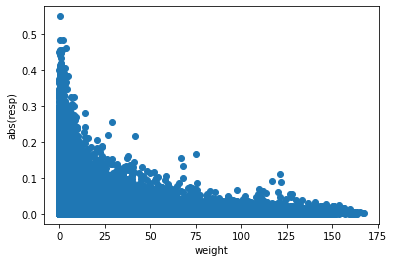

In [4]:
# scatter plot of weight and resp
plt.scatter(train_dataset['weight'], abs(train_dataset['resp']))
plt.xlabel('weight') 
# frequency label 
plt.ylabel('abs(resp)') 

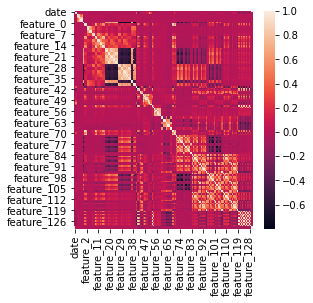

In [5]:
# correlation plot of all variates
plt.figure(figsize=(4,4))
df = train_dataset
cor = df.corr()
sns.heatmap(cor, annot=False, fmt='d')
plt.show()


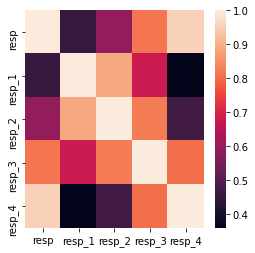

In [6]:
# correlation plot of a subset variates
plt.figure(figsize=(4,4))
df = train_dataset[['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']]
cor = df.corr()
sns.heatmap(cor, annot=False, fmt='d')
plt.show()

In [8]:
# Feature selection starts here

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


In [8]:
# This function selects a subset of features based on covariance
correlated_features = set()
correlation_matrix = train_dataset.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(correlated_features)

{'feature_50', 'resp_2', 'feature_117', 'feature_35', 'feature_123', 'feature_108', 'resp_4', 'feature_93', 'feature_94', 'feature_80', 'feature_67', 'feature_114', 'feature_68', 'feature_79', 'feature_119', 'feature_57', 'feature_8', 'feature_48', 'feature_32', 'feature_59', 'feature_128', 'feature_15', 'feature_34', 'feature_37', 'feature_69', 'feature_82', 'feature_91', 'feature_110', 'feature_112', 'feature_102', 'feature_4', 'feature_98', 'feature_76', 'feature_16', 'feature_87', 'feature_96', 'feature_99', 'feature_53', 'feature_14', 'feature_125', 'feature_122', 'feature_92', 'feature_113', 'resp_3', 'feature_18', 'feature_21', 'feature_33', 'feature_31', 'feature_107', 'resp', 'feature_111', 'feature_70', 'feature_129', 'feature_12', 'feature_104', 'feature_36', 'feature_105', 'feature_10', 'feature_78', 'feature_75', 'feature_120', 'feature_22', 'feature_127', 'feature_26', 'feature_28', 'feature_20', 'ts_id', 'feature_30', 'feature_106', 'feature_86', 'feature_29', 'feature_1

In [ ]:
# In another file we explore the subset of features selected by Borushap Package

In [ ]:
# Cleaning the dataset starts here!

In [4]:
# Remove the entries with weight 0 from the dataset
train_dataset_weight = train_dataset[train_dataset.weight != 0]
#train_dataset_weight = train_dataset
#(train_dataset_weight['weight'].values *
train_dataset_weight['action'] = ( train_dataset_weight['resp'].values > 0).astype('int')
train_dataset_weight.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1,0
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4,0
6,0,0.190575,-0.001939,-0.002301,0.001088,0.005963,0.000709,-1,-3.172026,-3.093182,...,0.336873,4.076447,0.614783,6.622176,0.800618,5.231595,0.361506,3.921714,6,1
7,0,3.820844,0.017395,0.021361,0.031163,0.036970,0.033473,-1,0.446050,-0.466210,...,2.101997,4.846202,1.479875,5.261328,2.305066,4.571762,2.201537,4.429745,7,1
8,0,0.116557,-0.005460,-0.007301,-0.009085,-0.003546,-0.001677,1,-3.172026,-3.093182,...,1.537913,4.785838,1.637435,6.968002,2.354338,5.825499,1.778029,4.740577,8,0


In [11]:
# The graph shows that the above method leads to a more balanced dataset
x = train_dataset_weight['action'].value_counts().index
y = train_dataset_weight['action'].value_counts().values
print(y)
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Blues',#'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance - action",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

[999387 981900]


In [5]:
# Imputated the missing values using the mean
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer(strategy='mean')

imputed_train_dataset_weight = pd.DataFrame(my_imputer.fit_transform(train_dataset_weight))

imputed_train_dataset_weight.columns = train_dataset_weight.columns

imputed_train_dataset_weight

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,0.0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1.0,-1.349537,-1.704709,...,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1.0,0.0
1,0.0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1.0,-3.172026,-3.093182,...,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4.0,0.0
2,0.0,0.190575,-0.001939,-0.002301,0.001088,0.005963,0.000709,-1.0,-3.172026,-3.093182,...,0.336873,4.076447,0.614783,6.622176,0.800618,5.231595,0.361506,3.921714,6.0,1.0
3,0.0,3.820844,0.017395,0.021361,0.031163,0.036970,0.033473,-1.0,0.446050,-0.466210,...,2.101997,4.846202,1.479875,5.261328,2.305066,4.571762,2.201537,4.429745,7.0,1.0
4,0.0,0.116557,-0.005460,-0.007301,-0.009085,-0.003546,-0.001677,1.0,-3.172026,-3.093182,...,1.537913,4.785838,1.637435,6.968002,2.354338,5.825499,1.778029,4.740577,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981282,499.0,56.694795,0.001607,0.001607,-0.001245,-0.012068,-0.010023,-1.0,1.538675,2.530447,...,-0.984942,1.129901,-1.632432,-2.169964,-2.371293,-0.889212,-1.554352,0.215984,2390444.0,0.0
1981283,499.0,1.650055,0.004523,0.004523,0.003172,-0.013886,-0.013637,1.0,0.270380,-1.231874,...,1.724863,-0.984278,1.413825,-1.598825,2.087731,-1.126050,1.590538,-1.250209,2390446.0,0.0
1981284,499.0,0.895142,0.000486,0.000486,-0.004090,-0.008105,-0.005441,-1.0,-0.134380,0.160580,...,-0.765664,-2.148415,-0.599358,-3.155134,-0.957971,-2.285314,-0.894580,-2.064227,2390478.0,0.0
1981285,499.0,2.967272,0.000298,0.000298,-0.005393,-0.012472,-0.006681,-1.0,-0.779554,-0.597258,...,1.173186,-1.215499,0.170404,-3.433334,0.496345,-2.224752,1.207851,-1.264984,2390481.0,0.0


In [6]:
# Based on above observations and basic analysis created the target and input variables. We carry further analysis
# to eliminate more variables
y = imputed_train_dataset_weight.action
X = imputed_train_dataset_weight.drop(['action', 'date',	'weight',	'resp_1',	'resp_2',	'resp_3',	'resp_4',	'resp', 'ts_id'], axis=1)

In [9]:
# We use selectkbest to see what features are more important given the target and the input variable
selector = SelectKBest(k=118)
X_new = selector.fit_transform(X, y)
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=X.index, 
                                 columns=X.columns)

In [13]:
#selected_features.info(verbose=True, null_counts=True)
selected_features




array(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21',
       'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33',
       'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_41',
       'feature_42', 'feature_43', 'feature_44', 'feature_46',
       'feature_48', 'feature_49', 'feature_50', 'feature_51',
       'feature_52', 'feature_53', 'feature_54', 'feature_55',
       'feature_56', 'feature_57', 'feature_58', 'feature_59',
       'feature_61', 'feature_62', 'feature_63', 'feature_64',
       'feature_65', 'feature_66', 'f

In [14]:
#selected_columns = selected_features.columns[selected_features.var() != 0]
#col = selected_columns.to_series()
#selected_features = col.values

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

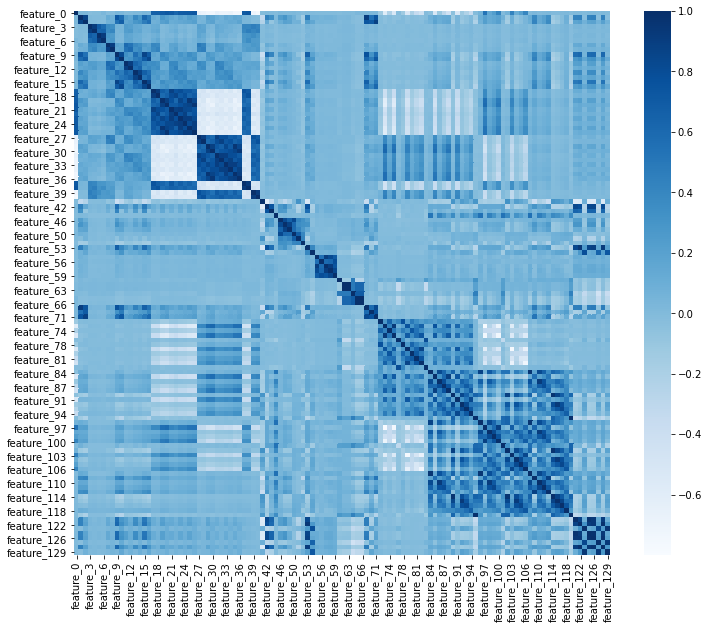

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_118,feature_119,feature_120,feature_122,feature_123,feature_124,feature_126,feature_127,feature_128,feature_129
0,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,...,6.649580,-1.472686,NaN,1.168391,8.313583,1.782433,2.653056,12.600292,2.301488,11.445807
1,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,...,1.612348,-1.664544,NaN,-1.178850,1.777472,-0.915458,-1.417010,2.297459,-1.304614,1.898684
2,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,...,1.817895,-2.432424,NaN,6.115747,9.667908,5.542871,7.281757,10.060014,6.638248,9.427299
3,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,...,0.099560,-2.485993,NaN,2.838853,0.499251,3.033732,4.397532,1.266037,3.856384,1.013469
4,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,...,2.134804,-1.279284,NaN,0.344850,4.101145,0.614252,0.800129,5.233243,0.362636,3.926633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390486,1,-1.649365,-1.169996,-0.889129,-1.256179,-0.265419,-0.383478,0.526201,1.162469,-0.712916,...,1.899095,2.613388,-2.421753,-1.260055,1.947725,-1.994399,-2.866165,-0.216130,-1.892048,0.901585
2390487,1,2.432943,5.284504,-0.337469,-0.494263,-0.442409,-0.739016,-0.064645,0.163244,-2.439639,...,-0.147595,0.425992,-0.677511,1.064936,3.119762,-0.419796,-0.146749,0.730166,0.648452,2.068737
2390488,1,-0.622475,-0.963682,0.532835,0.392287,0.977046,0.819693,0.140248,0.039213,-0.425500,...,0.760089,-0.145317,-0.459167,-0.640334,-2.279663,-0.950259,-1.669922,-3.288939,-1.336142,-2.814239
2390489,-1,-1.463757,-1.107228,-2.286985,-3.156451,-1.690676,-2.348199,-0.683812,-0.939522,-3.443777,...,8.534578,13.012635,-2.651236,-1.780962,0.881246,-2.202140,-3.341684,-0.571188,-2.185795,0.627452


In [15]:
# Shows how correlated the selected features are
plt.figure(figsize=(12,10))
df = train_dataset[selected_features]
cor = df.corr()
sns.heatmap(cor, annot=False, cmap='Blues')
plt.show()
df

In [16]:
# trying to see if correlation of variates in the features.csv file which intern gives

data_setfeature = pd.read_csv('../input/jane-street-market-prediction/features.csv')


In [17]:
data_setfeature_updt = data_setfeature*1
data_setfeature_updt = data_setfeature_updt.set_index('feature')
data_setfeature_updt.fillna(0)
data_setfeature_updt['Total'] = data_setfeature_updt[data_setfeature_updt.columns].sum(axis=1)
data_setfeature_updt = data_setfeature_updt.reset_index()
data_setfeature_updt1 = data_setfeature_updt[['feature','Total']]

#data_setfeature_updt2 = data_setfeature_updt1.sort_values(by='Total')
data_setfeature_updt2 = data_setfeature_updt1

In [18]:
x = data_setfeature_updt2['feature']
data2 = data_setfeature_updt.drop(columns=['feature','Total'],axis=1)
Num_data = data2.to_numpy()
z1 = Num_data
z2 = Num_data.T
output = z1.dot(z2)
print(output)


[[0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]
 [0 2 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 1 2]
 [0 0 0 ... 1 2 2]
 [0 0 0 ... 2 2 3]]


In [19]:
df = pd.DataFrame(data = output,  
                  index = x,  
                  columns = x) 

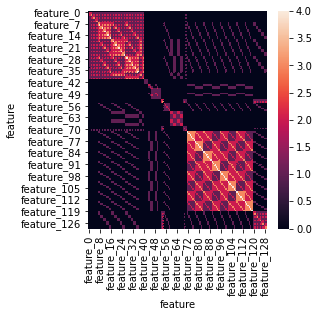

In [20]:
plt.figure(figsize=(4,4))
ax = sns.heatmap(df, annot=False, fmt="d")
plt.show()